In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

from datetime import datetime, timedelta
from GPSat import get_data_path, get_parent_path
from GPSat.dataprepper import DataPrep
from GPSat.utils import WGS84toEASE2_New, EASE2toWGS84_New, cprint, grid_2d_flatten, get_weighted_values
from GPSat.local_experts import LocalExpertOI, get_results_from_h5file
from GPSat.plot_utils import plot_pcolormesh, get_projection, plot_pcolormesh_from_results_data

def GCdist(X,Xs):
    radius = lambda lat : np.sqrt(((6378137**2 * np.cos(lat))**2 + (6356752**2 * np.sin(lat))**2/\
                                  (6378137 * np.cos(lat))**2 + (6356752 * np.sin(lat))**2))
    
    minlat = min(np.min(X.T[(1,)].T),np.min(Xs.T[(1,)].T))
    maxlat = max(np.max(X.T[(1,)].T),np.max(Xs.T[(1,)].T))
    lon1 = np.radians(X.T[(0,)].T) ; lat1 = np.radians(X.T[(1,)].T)
    lon2 = np.radians(Xs.T[(0,)].T) ; lat2 = np.radians(Xs.T[(1,)].T)
    r = 6356752#np.mean(radius(np.arange(minlat,maxlat)))
    
    Clat1 = np.cos(lat1) ; Clat2 = np.cos(lat2)
    Slat1 = np.sin(lat1) ; Slat2 = np.sin(lat2)
    Clon1 = np.cos(lon1) ; Clon2 = np.cos(lon2)
    Slon1 = np.sin(lon1) ; Slon2 = np.sin(lon2)
    
    n1 = np.array([Clat1*Clon1,Clat1*Slon1,Slat1]).T
    n2 = np.array([Clat2*Clon2,Clat2*Slon2,Slat2]).T
    return r*np.arccos(np.dot(n1,n2.T))

# Load data

In [2]:
#indices for GPOD data:
#0 = Lon
#1 = Lat
#2 = Interpolated SLA
#3 = Error in interpolated SLA
#4 = Freeboard
#5 = Pulse Peakiness
#6 = Lew
#7 = Class (1=Lead, 2=Floe, 3=OO)
#8 = Sigma 0
#9 = Raw Elevation
#10 = Mean Sea-surface
#11 = SIC
#12 = Sea ice type (0=FYI, 1=MYI)
#13 = Snow depth
#14 = Snow density
#15 = Sea ice thickness
#16 = GPOD SLA
#17 = GPOD SSH
#18 = GPOD SWH
#19 = Elevation from Samosa

interp_date = datetime(2019,1,15)
grab_dates = sorted([interp_date-timedelta(days=x) for x in range(5)]+[interp_date+timedelta(days=x) for x in range(1,5)])
grab_dates = [x.strftime('%Y%m%d') for x in grab_dates]

x = []
y = []
t = []
lon = []
lat = []
dates = []
classif = []
interpSLA = []
elev = []
satellite = []
trackID = []

dirs = sorted(glob.glob('/Users/wg4031/Dropbox/GPOD_DATA/*'))
count = 0
for directory in dirs:
    tracks = sorted(glob.glob(directory+'/*v1.proc'))
    SAT = directory.split('/')[-1]
    if (SAT == 'CS2_SARIN') or (SAT == 'CS2_SAR'):
        SAT = 'CS2'
    for track in tracks:
        date = track.split('/')[-1].split('T')[0].split('_')[-1]
        if date in grab_dates:
            time = 14975 + (datetime(int(date[:4]),int(date[4:6]),int(date[6:8]))-datetime(2011,1,1)).days
            f = np.genfromtxt(track)

            ID = np.where((f[:,7]<3) & (f[:,11]>=0.75))[0]
            classes = np.copy(f[ID,7]).astype(str)
            classes[classes=='1.0'] = 'lead'
            classes[classes=='2.0'] = 'floe'
            elvmss = f[ID,9]-f[ID,10]
            elvmss[classes=='floe'] = elvmss[classes=='floe']-0.1626 #subtract 16.26cm bias (see Lawrence et al., 2019)

            xg,yg = WGS84toEASE2_New(f[ID,0],f[ID,1])  
            N = len(xg)
            x.extend(xg)
            y.extend(yg)
            t.extend([time]*N)
            lon.extend(f[ID,0])
            lat.extend(f[ID,1])
            dates.extend([date]*N)
            classif.extend(classes)
            interpSLA.extend(f[ID,2])
            elev.extend(elvmss)
            satellite.extend([SAT]*N)
            trackID.extend([count]*N)
            count += 1

df = pd.DataFrame({'x':np.array(x),'y':np.array(y),'t':np.array(t),'lon':np.array(lon),'lat':np.array(lat),'date':np.array(dates),
                  'elevation':elev,'interpSLA':np.array(interpSLA),'class':np.array(classif),
                  'SAT':np.array(satellite),'track':np.array(trackID)})

df

,x,y,t,lon,lat,date,elevation,interpSLA,class,SAT,track
0,947448.687203,-488832.119832,17907,62.708721,80.443011,20190111,0.2297,NaN,lead,CS2,0
1,947680.718825,-489028.519289,17907,62.705059,80.440348,20190111,0.2057,0.2436,lead,CS2,0
2,947912.744886,-489224.918679,17907,62.701400,80.437686,20190111,0.2392,0.2432,lead,CS2,0
3,948144.776143,-489421.321425,17907,62.697742,80.435023,20190111,0.2544,0.2428,lead,CS2,0
4,948376.801017,-489617.725708,17907,62.694087,80.432361,20190111,0.2377,0.2424,lead,CS2,0
...,...,...,...,...,...,...,...,...,...,...,...
2063569,-766279.063373,574544.764128,17915,-126.862023,81.416562,20190119,0.1289,NaN,floe,S3B,877
2063570,-766082.222460,574814.733162,17915,-126.882009,81.416521,20190119,0.0204,NaN,floe,S3B,877
2063571,-765688.540353,575354.664293,17915,-126.921980,81.416437,20190119,0.1038,NaN,floe,S3B,877
2063572,-765491.690171,575624.619829,17915,-126.941964,81.416393,20190119,0.1352,NaN,floe,S3B,877


# Select profile for interpolation

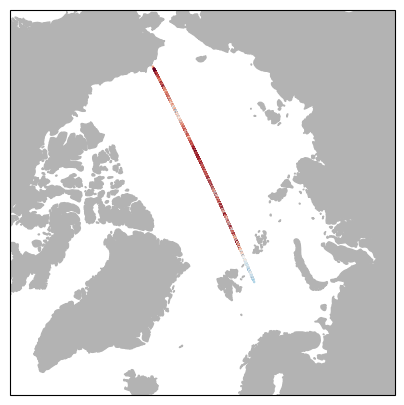

,x,y,t,lon,lat,date,elevation,interpSLA,class,SAT,track
387897,-721352.574060,1.972270e+06,17911,-159.910142,71.106008,20190115,0.0765,NaN,lead,CS2,105
387898,-721212.146745,1.972004e+06,17911,-159.911246,71.108718,20190115,0.1221,0.2910,lead,CS2,105
387899,-721071.715415,1.971738e+06,17911,-159.912349,71.111428,20190115,0.1203,0.2950,lead,CS2,105
387900,-707737.994071,1.946434e+06,17911,-160.018357,71.368866,20190115,0.3850,0.3201,lead,CS2,105
387901,-707457.441887,1.945901e+06,17911,-160.020614,71.374285,20190115,0.1397,0.3196,lead,CS2,105
...,...,...,...,...,...,...,...,...,...,...,...
395372,742263.922646,-1.130844e+06,17911,33.280107,77.864860,20190115,-0.0734,-0.0768,lead,CS2,105
395373,742380.731543,-1.131123e+06,17911,33.277757,77.862181,20190115,-0.0855,-0.0768,lead,CS2,105
395374,742497.533982,-1.131402e+06,17911,33.275407,77.859502,20190115,-0.1098,-0.0768,lead,CS2,105
395375,751717.101002,-1.153452e+06,17911,33.092727,77.647806,20190115,-0.0639,-0.0841,lead,CS2,105


In [3]:
interptrack = 105 #track on interp day 20190115
df_val = df.loc[df['track']==interptrack]


fig,ax = plt.subplots(1,figsize=(5,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
ax.set_extent([-180,180,65,90],ccrs.PlateCarree())
ax.add_feature(cfeat.LAND, color=(0.7,0.7,0.7))
ax.scatter(df_val['lon'],df_val['lat'],s=0.5,c=df_val['elevation'],cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
plt.show()

df_val

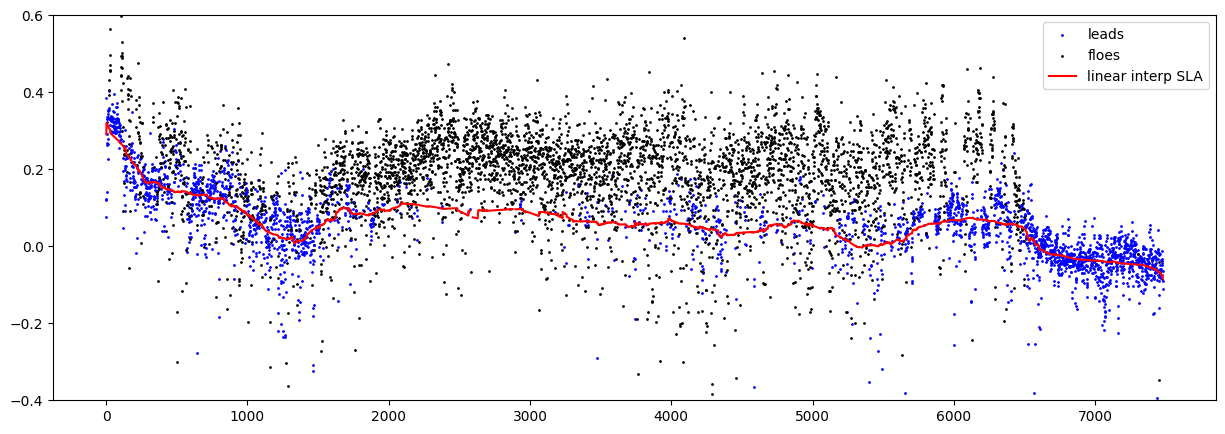

In [4]:
leads = np.where(df_val['class'] == 'lead')
floes = np.where(df_val['class'] == 'floe')
fig,ax = plt.subplots(1,figsize=(15,5))
ax.scatter(leads,df_val['elevation'].iloc[leads],color='b',s=1,label='leads')
ax.scatter(floes,df_val['elevation'].iloc[floes],color='k',s=1,label='floes')
ax.plot(np.arange(len(df_val['interpSLA'])),df_val['interpSLA'],color='r',label='linear interp SLA')
ax.set_ylim(-0.4,0.6)
ax.legend()
plt.show()

# Generate expert locations at 200 km

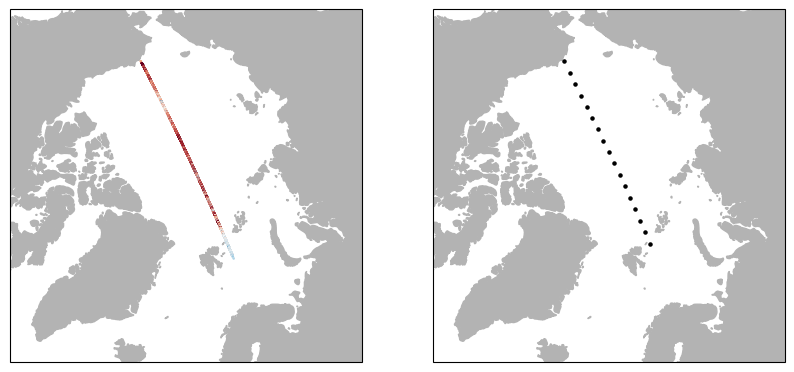

,x,y,t,lon,lat,date,elevation,interpSLA,class,SAT,track
387897,-721352.574060,1.972270e+06,17911,-159.910142,71.106008,20190115,0.0765,NaN,lead,CS2,105
388171,-629429.072718,1.796879e+06,17911,-160.695143,72.885470,20190115,0.1354,0.1677,lead,CS2,105
388585,-537650.078249,1.619503e+06,17911,-161.634624,74.673121,20190115,0.1417,0.1333,lead,CS2,105
388960,-446058.062505,1.440178e+06,17911,-162.790982,76.467810,20190115,0.0352,0.0659,lead,CS2,105
389233,-356328.511417,1.262205e+06,17911,-164.235284,78.235455,20190115,0.2307,0.0084,floe,CS2,105
389541,-267113.377118,1.082937e+06,17911,-166.144200,80.000143,20190115,0.0629,0.0902,lead,CS2,105
389873,-178581.952236,9.026977e+05,17911,-168.809590,81.753796,20190115,0.2142,0.0919,floe,CS2,105
390413,-91030.218050,7.220883e+05,17911,-172.814898,83.480149,20190115,0.1972,0.0885,floe,CS2,105
391014,-4351.235244,5.408929e+05,17911,-179.539092,85.155651,20190115,-0.0812,0.0879,floe,CS2,105
391577,81686.656041,3.586163e+05,17911,167.167942,86.706566,20190115,0.0244,0.0560,lead,CS2,105


In [5]:
#divide track into 200 km points for expert locations
Xs = np.array([df_val['lon'],df_val['lat']]).T
r_exp = GCdist(Xs,Xs) #compute distance matrix
exp_grid = np.arange(0,np.sum(r_exp[0,:]),200e3)
locs = []
for ix in exp_grid:
    temp = np.abs(r_exp[0,:]-ix)
    dm = np.where(temp==np.min(temp))
    if len(locs)<=16:
        locs.append(dm[0][0])
        
fig,ax = plt.subplots(1,2,figsize=(10,5),subplot_kw=dict(projection=ccrs.NorthPolarStereo()))
for c in range(2):
    ax[c].set_extent([-180,180,65,90],ccrs.PlateCarree())
    ax[c].add_feature(cfeat.LAND, color=(0.7,0.7,0.7))
    if c == 0:
        ax[c].scatter(df_val['lon'],df_val['lat'],c=df_val['elevation'],s=0.5,cmap='RdBu_r',vmin=-0.3,vmax=0.3,transform=ccrs.PlateCarree())
    else:
        ax[c].scatter(df_val['lon'].iloc[locs],df_val['lat'].iloc[locs],s=5,c='k',transform=ccrs.PlateCarree())
plt.show()

experts = df_val.iloc[locs]
experts

# Interpolate along-track

In [ ]:
#WHERE TO SAVE
store_path = get_parent_path("/Users/wg4031/Dropbox/", "GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5")


#SET PARAMETERS OF MODEL (e.g., use data within 300 km and +/- 4 days)
data = {
    "data_source": df.loc[(df['class']=='lead') & (np.abs(df['elevation'])<0.6) & (~np.isnan(df['elevation']))],
    "obs_col": "elevation",
    "coords_col": ["x", "y", "t"],
    # selection criteria used for each local expert                                                                                                                                                                   
    "local_select": [
        {
            "col": [
                "x",
                "y"
            ],
            "comp": "<=",
            "val": 100_000
        },
        {
            "col": "t",
            "comp":"<=",
            "val":2
        },
        {
            "col": "t",
            "comp":">=",
            "val":-2
        }
    ],
    "global_select": [
        {
            "col": "lat",
            "comp": ">=",
            "val": 45
        }
    ]
}

#GIVE DATAFRAME OF EXPERTS
local_expert = {
    "source": experts
}

#GIVE DATAFRAME OF PREDICTION LOCATIONS (predict at all lead and floe locations along track)
pred_loc = {
    "method": "from_dataframe",
    "df": df_val,
    "max_dist": 200_000
}


#SETUP SPARSE GP MODEL (PLAY WITH MINIBATCH AND INDUCING POINTS)
model = {
    "oi_model": "GPflowSVGPModel",
    "init_params": {
        # scale (divide) coordinates                                                                                                                                                                                  
        "coords_scale": [10000, 10000, 1],
        "minibatch_size": 100,
        "num_inducing_points":200
    },
    "constraints": {
        # lengthscales - same order coord_col (see data)                                                                                                                                                              
        "lengthscales": {
            "low": [1e-08, 1e-08, 1e-08],
            "high": [200000, 200000, 4]
        }
    }
}

locexp = LocalExpertOI(expert_loc_config=local_expert,
                       data_config=data,
                       model_config=model,
                       pred_loc_config=pred_loc)

# run optimal interpolation                                                                                                                                                                                           
locexp.run(store_path=store_path,
           optimise=True)

#SMOOTH HYPERPARMETERS
smooth_configs = {"lengthscales": dict(l_x=200_000, l_y=200_000, max=12),                                                                                                                                  
                  "likelihood_variance": dict(l_x=200_000, l_y=200_000),                                                                                                                                   
                  "kernel_variance": dict(l_x=200_000, l_y=200_000, max=0.1)}                                                                                                                              
                                                                                                                                                                                                                      
smooth_hyperparameters(result_file=store_path,                                                                                                                                                                        
                       params_to_smooth=["lengthscales", "kernel_variance", "likelihood_variance"],                                                                                                                   
                       smooth_config_dict=smooth_configs,                                                                                                                                                             
                       save_config_file=False)                                                                                                                                                                        
                                                                                                                                                                                                                      
# %%                                                                                                                                                                                                                  
# ---                                                                                                                                                                                                                 
# Make predictions with smoothed hyperparameters                                                                                                                                                                      
# ---                                                                                                                                                                                                                 
model['load_params'] = {"file": store_path, "table_suffix": "_SMOOTHED"}                                                                                                                                              
locexp = LocalExpertOI(expert_loc_config=local_expert,                                                                                                                                                                
                       data_config=data,                                                                                                                                                                              
                       model_config=model,                                                                                                                                                                            
                       pred_loc_config=pred_loc)                                                                                                                                                                      
                                                                                                                                                                                                                      
locexp.run(store_path=store_path,                                                                                                                                                                                     
           optimise=False,                                                                                                                                                                                            
           predict=True,                                                                                                                                                                                              
           table_suffix='_SMOOTHED')

with pd.HDFStore(store_path) as store:
    store.remove('inducing_mean')
    store.remove('inducing_mean_SMOOTHED')                                                                                                                                                                           
    store.remove('inducing_chol')
    store.remove('inducing_chol_SMOOTHED')                                                                                                                                                                           
    store.remove('inducing_points')
    store.remove('inducing_points_SMOOTHED')                                                                                                                                                                         

os.system('ptrepack --chunkshape=auto --propindexes --complib=blosc '+store_path+' temp_store_3D.csv')
os.system('rm '+store_path)
os.system('mv temp_store_3D.csv '+store_path)

print('Done!')

'data_select': 0.000 seconds
'load': 0.000 seconds
in json_serializable - key: 'data_source' has value DataFrame/Series, but is too long: 933261 >  100
storing as str


In [ ]:
import pandas as pd

df = pd.DataFrame({'x':[0,1,2,3,4],'y':[5,6,7,8,9]})
#df.to_hdf('~/Documents/test.h5','data')

predictions = pd.read_hdf("/Users/wg4031/Dropbox/GPSatSVGP_CS2S3_alongtrack_SLA_3D.h5",'preds_SMOOTHED')



In [1]:
from GPSat.postprocessing import glue_local_predictions

In [2]:
predictions_glued = glue_local_predictions(predictions,experts)

Signature:
 glue_local_predictions(
    preds_df: pandas.core.frame.DataFrame,
    inference_radius: pandas.core.frame.DataFrame,
    R: Union[int, float, list] = 3,
) -> pandas.core.frame.DataFrame
Docstring:
DEPRECATED. See ``glue_local_predictions_1d`` and ``glue_local_predictions_2d``.
Glues overlapping predictions by taking a normalised Gaussian weighted average.


Parameters
----------
preds_df: pd.DataFrame
    containing predictions generated from local expert OI. It should have the following columns:
    - pred_loc_x (float): The x-coordinate of the prediction location.
    - pred_loc_y (float): The y-coordinate of the prediction location.
    - f* (float): The predictive mean at the location (pred_loc_x, pred_loc_y).
    - f*_var (float): The predictive variance at the location (pred_loc_x, pred_loc_y).
expert_locs_df: pd.DataFrame
    containing local expert locations used to perform OI. It should have the following columns:
    - x (float): The x-coordinate of the expert lo